In [1]:
# load modules
#--------------------------------------------------------------
import numpy as np
import pandas as pd
import sys, os, time
import datetime
import re
import seaborn as sns
from scipy.stats import norm
import matplotlib.pyplot as plt
import ray
sys.path.append('../..')

# import helpers
from src.utils import interp, get_xs, Params, get_xtv
from src.plots import scatter_plot, line_plot


from src.models.chain_gaussian import Chain_Gaussian
from src.mcmc_diagnostics.diagnostic import MCMCDiagnostic
from src.utils.serialize import pickle_obj, unpickle_obj, load_json, save_json

# import sampler classes
from src.sampling_algorithms import MaskedLocalBPS, LocalBPS
from src.sampling_algorithms.masked_bps.masked_bps_output import OutputReader,output_chain_fp_constructor, states_fp_constructor
from src.plots.arrow_plot import arrow_plot
# plot settings
from matplotlib import rc
rc('text', usetex=True)

import arviz as az
from arviz.stats import ess
az.style.use('arviz-darkgrid')

In [2]:
params = Params({
    "refresh_rate": 0.1,
    "overlap": 1,
    "num_factors": 1,
    "factor_dim": 3,
    "mu": 0.,
    "prec":1.,
    "rho": 0.,
    'run_time': 30,
    'num_workers': 5
})
output_dir = "./output"

In [3]:
## Define model
model = Chain_Gaussian(params)
parent_dir = '../..'
os.environ["PYTHONPATH"] = parent_dir + ":" + os.environ.get("PYTHONPATH", "")

# Shutdown and init ray
if ray.is_initialized():
    ray.shutdown()

ray.init(memory=10**9, object_store_memory = 10**9)




# custom mask for demo, may result in errors if params edited and whole factor is masked!
def sample_mask_fn():
    mask = np.repeat(1., model.chain_length)
    ind_to_mask = np.random.choice(model.chain_length,1)
    mask[ind_to_mask] = 0.
    return mask

init_mask = sample_mask_fn()



# init values
init_x = np.array([np.random.rand() for _ in range(model.chain_length)])
init_v = np.array([np.random.rand() for _ in range(model.chain_length)])

# init sampler
#--------------------------------------------------------------------------------------
mlbps = MaskedLocalBPS(init_x = init_x,
                       init_v = init_v,
                       init_mask = init_mask,
                       factor_graph=model,
                       bounce_fns=model.bounce_fns,
                       refresh_rate=model.params.refresh_rate,
                       split_mask_fn = model.split_mask_into_groups,
                       sample_mask_fn=sample_mask_fn,
                       max_number_sub_samplers = params.num_workers)

2020-02-20 12:35:32,062	WARNING worker.py:682 -- WARNING: Not updating worker name since `setproctitle` is not installed. Install this with `pip install setproctitle` (or ray[debug]) to enable monitoring of worker processes.
2020-02-20 12:35:32,070	WARNING services.py:592 -- setpgrp failed, processes may not be cleaned up properly: [Errno 1] Operation not permitted.
2020-02-20 12:35:32,179	INFO resource_spec.py:212 -- Starting Ray with 0.93 GiB memory available for workers and up to 0.93 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).
2020-02-20 12:35:32,433	WARNING services.py:856 -- Redis failed to start, retrying now.
2020-02-20 12:35:32,605	WARNING services.py:1080 -- Failed to start the dashboard. The dashboard requires Python 3 as well as 'pip install aiohttp psutil setproctitle grpcio'.
2020-02-20 12:35:32,676	WARNING services.py:1004 -- Failed to start the reporter. The reporter requires 'pip install psutil'.


In [4]:
print('Masked Local BPS')
print(datetime.datetime.now())
res = mlbps.simulate_for_time(params.run_time, output_dir)
results, groups, masks = res
print(datetime.datetime.now())

Masked Local BPS
2020-02-20 12:35:33.196605
2020-02-20 12:36:15.723135


In [5]:
output_reader = OutputReader(mlbps)

In [6]:
output_reader = OutputReader(mlbps)

output, num_iter = output_reader.read_output(output_dir, verbose = False, inplace=False)

chains = {}
for i in range(mlbps.d):
    x, v, t, mask = output[i]['x'], output[i]['v'], output[i]['t'], output[i]['mask']
    x = np.array(x)
    v = np.array(v)
    t = np.array(t)
    mask = np.array(mask)
    nsim = len(x)
    xs = interp(x, t, v*mask, num_intervals= 10**5)
    chains["$x_{0}$".format(i)] = xs

In [7]:
masked_diag = MCMCDiagnostic(chains)

/data/greyheron/oxwasp/oxwasp18/thornton/venvs/masked_venv/lib64/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f2cd7fcef90>,
      dtype=object)

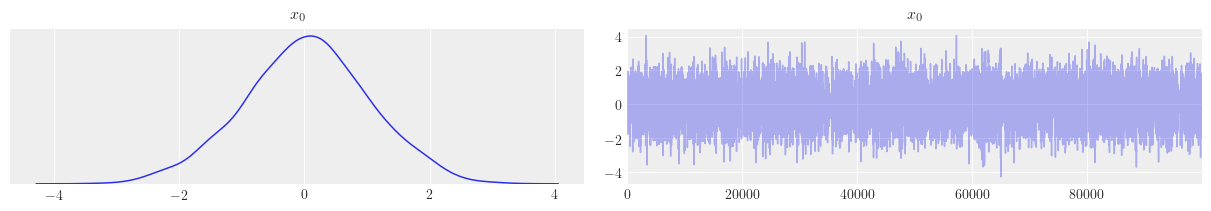

In [8]:
masked_diag.trace_plot('$x_0$')


/data/greyheron/oxwasp/oxwasp18/thornton/venvs/masked_venv/lib64/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f2cd6d8c190>,
      dtype=object)

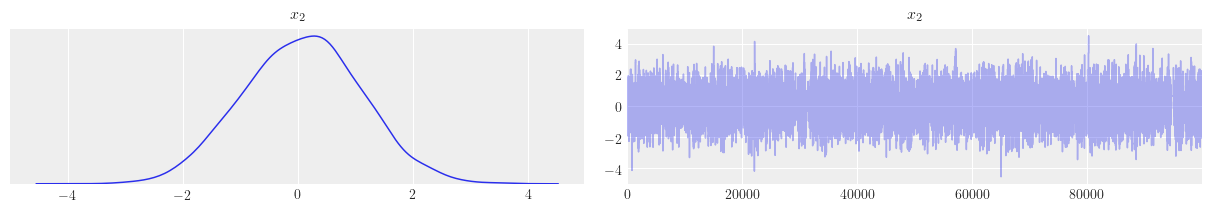

In [9]:
masked_diag.trace_plot('$x_2$')



In [10]:
sample_mask_fn()

array([0., 1., 1.])

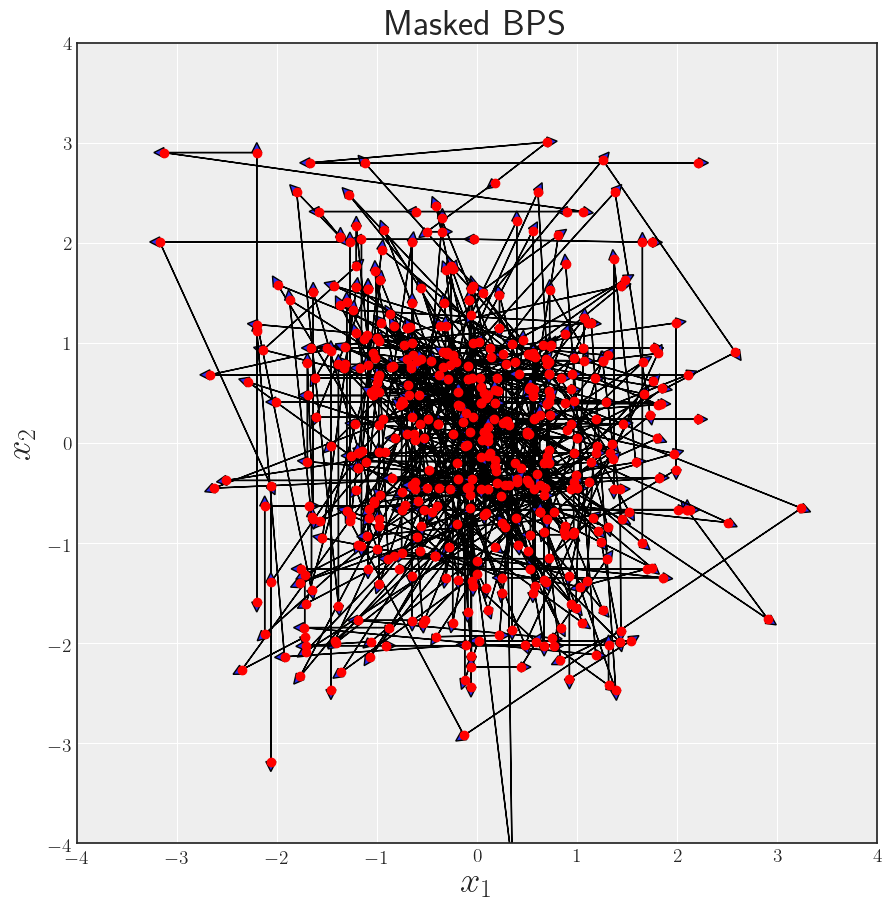

In [11]:
plot_limit = 500
x1 = np.array(output[1]['x'])
x2 = np.array(output[2]['x'])
fig_size = (10,10)
plt.rcParams["axes.edgecolor"] = "0.15"
plt.rcParams["axes.linewidth"]  = 1.25

font = {
        'weight' : 'bold',
        'size'   : 22}

plt.rc('font', **font)


fig = plt.figure(figsize=fig_size,frameon =True)
left, bottom, width, height = 0.1, 0.1, 0.8, 0.8
ax = fig.add_axes([left, bottom, width, height])
ax.set_title("Masked BPS", fontsize='large', fontweight='bold')
ax.set_xlabel("$x_1$",fontsize='large', fontweight='bold')
ax.set_ylabel("$x_2$",fontsize='large', fontweight='bold')

ax.set_xlim((-4,4))
ax.set_ylim((-4,4))
arrow_plot(x1[:plot_limit],x2[:plot_limit])
fig.savefig('./masked_bps.eps', format='eps', dpi=1200)


0.9922551636094197
1.0382807319905751


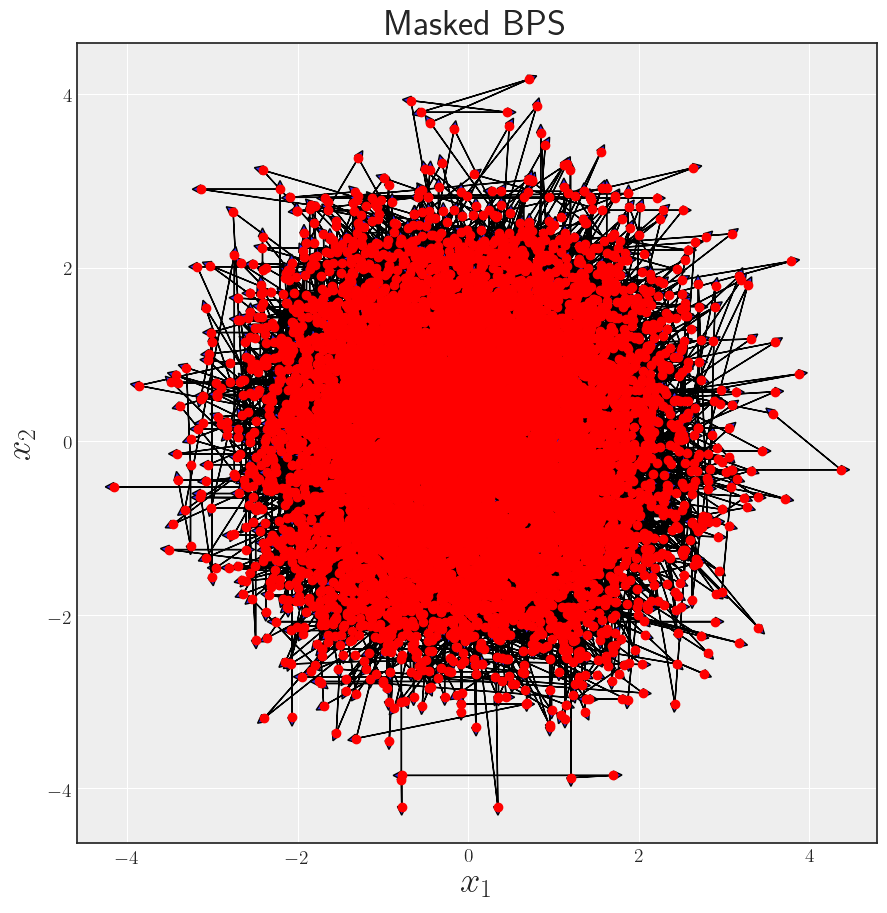

In [12]:
plot_limit = 10**4
fig_size = (10,10)

chain1= masked_diag.get_chain('$x_1$')[0]
print(np.var(chain1[~np.isnan(chain1)]))

chain2 = masked_diag.get_chain('$x_2$')[0]
print(np.var(chain2[~np.isnan(chain2)]))


plt.rcParams["axes.edgecolor"] = "0.15"
plt.rcParams["axes.linewidth"]  = 1.25

font = {
        'weight' : 'bold',
        'size'   : 22}

plt.rc('font', **font)


fig = plt.figure(figsize=fig_size,frameon =True)
left, bottom, width, height = 0.1, 0.1, 0.8, 0.8
ax = fig.add_axes([left, bottom, width, height])
ax.set_title("Masked BPS", fontsize='large', fontweight='bold')
ax.set_xlabel("$x_1$",fontsize='large', fontweight='bold')
ax.set_ylabel("$x_2$",fontsize='large', fontweight='bold')
#plt.plot(chain1,chain2,'ro')
arrow_plot(x1[:plot_limit],x2[:plot_limit])

In [13]:
chain = chain1
print("Mean: {0}".format(np.mean(chain)))
print("Var: {0}".format(np.var(chain)))
print("Moment 3: {0}".format(np.mean(((chain - np.mean(chain))/np.sqrt(np.var(chain)))**3)))
print("Moment 4: {0}".format(np.mean(((chain - np.mean(chain))/np.sqrt(np.var(chain)))**4)))

      
      


Mean: -0.014944946595921936
Var: 0.9922551636094197
Moment 3: 0.020267746060871877
Moment 4: 2.963737133671171
